In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib widget
import ssm
import copy
from tqdm import tqdm
import pickle 
import matplotlib.gridspec as gridspec
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import linkage, leaves_list, dendrogram, fcluster
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display
from ssm.util import random_rotation, find_permutation
from ipywidgets import interact, IntSlider
import sys
import glob
sys.path.append("/Users/friederikebuck/Desktop/MBL/project/WholeBrainImagingAnalysis/collab/")
sys.path.append('/Users/bennetsakelaris/Documents/Obsidian Vault/Worms/wormcode/Code+Notes 09-24-24/collab/')
from collections import defaultdict
import random 
from scipy.ndimage import gaussian_filter1d
from get_data.read_neuro_beh_data import get_exp_features, load_json
from get_data.process_neural_data import get_derivative_of_neural_activity, get_neural_activity_from_labels, get_neural_activity_and_labels
from beh_classification.behavior_features import get_behavior_features
from beh_classification.get_behavior_classifications import get_behavior_classification
from beh_classification.beh_classification_utils import get_start_end_is_of_ones_in_binary_array
import socket
import sklearn
from sklearn.cross_decomposition import CCA
from sklearn.utils import shuffle
import os
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import balanced_accuracy_score
from sklearn import svm
from matplotlib.gridspec import GridSpec
from sklearn.svm import LinearSVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from tqdm import tqdm
from sklearn.metrics import accuracy_score
from sklearn.neighbors import NearestNeighbors

import torch
import torch.nn as nn
import torch.optim as optim

def smooth_trace(raw_trace, sigma = 2):
    denoised_data = gaussian_filter1d(raw_trace, sigma=sigma)
    return denoised_data

def shift_array_by_one(array):
    _, n_dim = array.shape
    tmp = np.ones((T, n_dim))*np.nan
    tmp[1:] = array
    array = tmp
    return array


def load_all_data():
    # this just returns lists of traces, neural labels, and behavior for each worm
    # Also includes dtrace
    # be warned that all elements of the list have different shapes

    host = socket.gethostname()[0:6]
    if host == 'Bennet' or host == 'bennet' or 'northwestern' in socket.gethostname():
        json_dir = "/Users/bennetsakelaris/Documents/Obsidian Vault/worms/wormcode/data/Neuropal_no_heat/"
        h5_dir = "/Users/bennetsakelaris/Documents/Obsidian Vault/worms/wormcode/data/processed_h5/"
        beh_data_dir_parent = "/Users/bennetsakelaris/Desktop/behavior/outputs_sparse/"
    else:
        json_dir = "/Users/friederikebuck/Desktop/MBL/project/data/Neuropal_no_heat/"
        h5_dir ="/Users/friederikebuck/Desktop/MBL/project/data/processed_h5/"
        beh_data_dir_parent = "/Users/friederikebuck/Desktop/MBL/project/outputs/"



    directories = glob.glob(json_dir+"*.json") #get filename/paths of all the json files
    exp_dates = [directory.split("/")[-1].split(".")[0] for directory in directories] #extract the exp_dates
    for i in range(len(exp_dates)):
        print("Worm {}, date: {}".format(i, exp_dates[i]))

    full_traces = []
    full_neural_labels = []
    full_beh_classification = []
    full_beh_data = []

    for exp_date in exp_dates:
        dt, T, beh_data, neural_data, neuroID_to_key = get_exp_features(exp_date, 
                                                                    json_dir = json_dir, 
                                                                    h5_dir = h5_dir)
        behavior_features = get_behavior_features(beh_data)
        beh_data.update(behavior_features)
        behavior_classification = get_behavior_classification(beh_data)

        beh_data_dir = os.path.join(beh_data_dir_parent, str(exp_date), "csvs1")
        csv_name = os.path.join(beh_data_dir, "beh_confocal.csv")
        beh_confocal = np.loadtxt(csv_name, delimiter=",")
        z_beh = beh_confocal
        
        behavior_classification = {
        "is_fwd": beh_confocal==0, 
        "is_rev": beh_confocal==1, 
        "is_turn": beh_confocal==2, 
        "is_pause":  beh_confocal==3,
        }

        neural_labels_orig, ftrace = get_neural_activity_and_labels(neural_data,  denoised = True)

        dtrace = get_derivative_of_neural_activity(smooth_trace(ftrace.T,sigma=5).T, dframes = 1)
        dtrace -= np.mean(dtrace,axis=0)
        dtrace /= np.std(dtrace,axis=0)
        traces = np.concatenate([ftrace[1:,: ],dtrace ], axis =1)
        neural_labels = np.array(["F - "+ lbl[0] for lbl in neural_labels_orig]+
                                ["dF - "+ lbl[0] for lbl in neural_labels_orig])
        
        full_traces.append(traces)
        full_neural_labels.append(neural_labels)
        full_beh_classification.append(behavior_classification)
        full_beh_data.append(beh_data)

    return full_traces, full_neural_labels, full_beh_classification, full_beh_data
        


def load_all_data_but_pretend_its_all_one_worm():
    # This function concatenates everything into one worm and also returns a mask that tells you which neurons are and arent present
    # Thing to ponder: adding columns of NaNs between worms would probably help the rSLDS learn better
    full_traces, full_neural_labels, full_beh_classification, full_beh_data = load_all_data()

    #get list of all neurons recorded in at least one trial
    neural_labels_set = set()
    for nl in full_neural_labels:
        neural_labels_set = neural_labels_set.union(set(nl))
    neural_labels = np.sort(list(neural_labels_set))

    #now make the traces array, where the different recordings are concatenated and matched by neuron
    #note: a couple of worms have 15 extra timesteps. I am truncating those to make things easier down the line
    T = 1599
    traces = np.zeros((T*len(full_traces), neural_labels.shape[0]))*np.nan #initialize traces to nan 
    #build the traces matrix
    w=0
    for tr, labels, in zip(full_traces, full_neural_labels): #for each worm, w
        for i in range(tr.shape[1]): #for each neuron, i
            label = labels[i] #get neuron name
            idx = np.where(neural_labels==label)[0][0] #get index in full array
            traces[w*T:(w+1)*T, idx] = tr[0:T,i] #put the neuron's activity in the appropriate spot
        w+=1 #update worm index

    

    #set up behavior classification dict
    behavior_classification = dict()
    behavior_classification["is_turn"] = np.zeros(T*len(full_traces))
    behavior_classification["is_pause"] = np.zeros(T*len(full_traces))
    behavior_classification["is_rev"] = np.zeros(T*len(full_traces))
    behavior_classification["is_fwd"] = np.zeros(T*len(full_traces))
    behavior_classification["is_revturn"] = np.zeros(T*len(full_traces))
    behavior_classification["is_purerev"] = np.zeros(T*len(full_traces))
    behavior_classification["is_pureturn"] = np.zeros(T*len(full_traces))
    behavior_classification["is_rev_of_rev_turn"] = np.zeros(T*len(full_traces))
    behavior_classification["is_turn_of_rev_turn"] = np.zeros(T*len(full_traces))

    #fill it in
    w=0
    for bc in full_beh_classification:
        for key in bc.keys():
            behavior_classification[key][w*T:(w+1)*T] = bc[key][1:(T+1)] # shifting by one bc of the trace
        w+=1 #update worm index

    #return mask of nan data
    mask =  (~np.isnan(traces)).astype(int)
    return traces, neural_labels, behavior_classification, mask

# removes neurons that were only recorded in fewer than [threshold] experiments
def remove_rare_neurons(traces, neural_labels, mask, threshold=10): 
    n_occurances = np.zeros(traces.shape[1]) #count the number of occurances for each neuron
    for n in np.arange(0, traces.shape[1]):
        n_occurances[n] = sum(~np.isnan(traces[np.arange(100, traces.shape[0], 1599),n]))
    print("Removing {} neurons that are not recorded in more than {} experiments".format(sum(n_occurances<=threshold)/2, threshold))
    print("{} neurons remaining".format(sum(n_occurances>threshold)/2))
    
    traces = traces[:, n_occurances>threshold]
    neural_labels = neural_labels[n_occurances>threshold]
    mask = mask[:, n_occurances>threshold]
    return traces, neural_labels, mask


from matplotlib.colors import LinearSegmentedColormap

#color palette for plotting, colors as in make_behavior_ethogram
palette = ["coral",     # forward
           "lightblue", # reverse
           "darkgreen", # turn
           "purple","red", "yellow", "black", "pink"]    # pause
cmap = LinearSegmentedColormap.from_list("behavior", palette, N=len(palette))

def states_to_changepoints(z):
    assert z.ndim == 1
    z = np.array(z)
    return np.concatenate(([0], 1 + np.where(np.diff(z))[0], [z.size - 1]))

def plot_2d_continuous_states(x, z,
                              colors=palette,
                              ax=None,
                              inds=(0,1),
                              figsize=(2.5, 2.5),
                              **kwargs):

    if ax is None:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111)

    cps = states_to_changepoints(z)

    # Color denotes our inferred latent discrete state
    for cp_start, cp_stop in zip(cps[:-1], cps[1:]):
        ax.plot(x[cp_start:cp_stop + 1, inds[0]],
                x[cp_start:cp_stop + 1, inds[1]],
                 '-', color=colors[z[cp_start]],
                **kwargs)

def plot_dynamic_landscape(model,k,
    xlim=(-4, 4), ylim=(-3, 3), nxpts=20, nypts=20,
    alpha=0.3, ax=None, figsize=(3, 3), color=None):
    assert model.D == 2
    K = model.K
    x = np.linspace(*xlim, nxpts)
    y = np.linspace(*ylim, nypts)
    X, Y = np.meshgrid(x, y)
    xy = np.column_stack((X.ravel(), Y.ravel()))

    # Get the probability of each state at each xy location
    try:
        z = np.argmax(xy.dot(model.transitions.Rs.T) + model.transitions.r, axis=1)
    except:
        z = np.argmax(xy.dot(model.transitions.Rs.T), axis=1)

    if ax is None:
        fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

    dxydt_m = xy.dot(model.dynamics.As[k].T) + model.dynamics.bs[k] - xy
    dxydt_m_norm = np.zeros((len(dxydt_m)))
    for xt in range(len(dxydt_m_norm)):
        dxydt_m_norm[xt] = np.linalg.norm(dxydt_m[xt,:])

    ax.plot_trisurf(xy[:,0], xy[:,1], dxydt_m_norm, cmap = "coolwarm", linewidth=0, antialiased=False)

    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')

    plt.tight_layout()

    return ax

def plot_most_likely_dynamics(model, test_x, test_z, pca_x, other_pcs = False, input_str=0, input_id=0, ax=None, lim = None, plot_trajectory=True, inds=(0,1), do_pca=True, velocity=False):
    ind1,ind2 = inds
    pca = PCA(n_components=pca_x.shape[1])
    x_centered = pca_x - np.mean(pca_x, axis=0)
    pca.fit(x_centered)  # X is your trajectory data matrix
    X_pca = pca.transform(test_x - np.mean(pca_x, axis=0) )
    
    K = model.K
    # Define grid limits based on PCA-transformed trajectory
    if lim == None:
        x_min, x_max = X_pca[:, ind1].min() - 3, X_pca[:, ind1].max() + 3
        y_min, y_max = X_pca[:, ind2].min() - 3, X_pca[:, ind2].max() + 3
        lim = [x_min, x_max, y_min, y_max]
    else:
        x_min = lim[0]
        x_max = lim[1]
        y_min = lim[2]
        y_max = lim[3]

    # Create a grid of points
    x = np.linspace(x_min, x_max, 30)  # 30 grid points along x-axis
    y = np.linspace(y_min, y_max, 30)  # 30 grid points along y-axis
    X_grid, Y_grid = np.meshgrid(x, y)  # Create the grid

    # Inverse transform to get high-dimensional coordinates of grid points
    xy = np.column_stack(pca_x.shape[1]*[0*Y_grid.ravel()])
    xy[:,ind1] = X_grid.ravel()
    xy[:,ind2] = Y_grid.ravel()

    if (np.abs(input_str) > 0) and other_pcs:
        for i in range(xy.shape[1]):
            if (i != ind2) and (i!= ind1):
                xy[:,i] = X_pca[:,i].mean() + 0*Y_grid.ravel()

    if do_pca:
        xy_high_dim = pca.inverse_transform(xy)  # Map back to original space
    else:
        xy_high_dim = xy

    # Get the probability of each state at each xy location
    try:
        z = np.argmax(xy_high_dim.dot(model.transitions.Rs.T) + model.transitions.r, axis=1)
    except:
        z = np.argmax(xy_high_dim.dot(model.transitions.Rs.T), axis=1)

    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)

    velocity_magnitudes = np.zeros_like(X_grid.ravel())

    if model.M == 0:
        for k, (A, b) in enumerate(zip(model.dynamics.As, model.dynamics.bs)):
            next_step_high_dim = xy_high_dim @ A.T + b  # x_t+1 = Ax_t + b
            # Map back to PCA space for visualization
            if do_pca:
                next_step_pca = next_step_high_dim @ pca.components_.T
            else:
                next_step_pca = next_step_high_dim

            zk = z == k
            if zk.sum(0) > 0:
                ax.quiver(xy[zk, ind1], xy[zk, ind2],
                        next_step_pca[zk, ind1]-xy[zk,ind1], next_step_pca[zk, ind2]-xy[zk,ind2],
                        color=palette[k % len(palette)], alpha=1)
            velocity_magnitudes[zk] = np.linalg.norm(next_step_pca[zk] - xy[zk], axis=1)
    else:
        for k, (A, b, V) in enumerate(zip(model.dynamics.As, model.dynamics.bs, model.dynamics.Vs)):
            next_step_high_dim = xy_high_dim @ A.T + b + input_str*V[:,input_id] # x_t+1 = Ax_t + b
            # Map back to PCA space for visualization
            if do_pca:
                next_step_pca = next_step_high_dim @ pca.components_.T
            else:
                next_step_pca = next_step_high_dim

            zk = z == k
            if zk.sum(0) > 0:
                ax.quiver(xy[zk, ind1], xy[zk, ind2],
                        next_step_pca[zk, ind1]-xy[zk,ind1], next_step_pca[zk, ind2]-xy[zk,ind2],
                        color=palette[k % len(palette)], alpha=1)
                velocity_magnitudes[zk] = np.linalg.norm(next_step_pca[zk] - xy[zk], axis=1)
            
    if velocity:
        ax.cla()
         # Reshape velocity magnitudes to match grid
        velocity_magnitudes = velocity_magnitudes.reshape(30, 30)

        if ax is None:
            fig, ax = plt.subplots(figsize=(6, 6))

        # Plot the velocity heatmap
        heatmap = ax.pcolormesh(X_grid, Y_grid, velocity_magnitudes, cmap="Purples", shading='auto')
        plt.colorbar(heatmap, ax=ax, label="Velocity Magnitude")
                
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')

    plt.tight_layout()
    if plot_trajectory:
        if do_pca:
            plot_2d_continuous_states(X_pca, test_z, ax=ax, inds=inds)
        else:
            plot_2d_continuous_states(test_x, test_z, ax=ax, inds=inds)
    ax.set_xlim(x_min+2, x_max-2)
    ax.set_ylim(y_min+2, y_max-2)

    return ax, lim

def input_slds(slds, neural_labels, input_list_dynamics, input_list_emissions=[]):
    new_slds = copy.deepcopy(slds)

    new_slds.M += len(input_list_dynamics) + len(input_list_emissions)
    new_slds.emissions.M = new_slds.M
    new_slds.dynamics.M = new_slds.M
    new_slds.transitions.M = new_slds.M

    # Inititalize new input-driven properties
    Vs = np.zeros((new_slds.K, new_slds.D, new_slds.M))
    Fs = np.zeros((1, new_slds.N, new_slds.M))
    Ws = np.zeros((new_slds.K, new_slds.M))

    if slds.M > 0: #if old slds already supported inputs
        Vs[:,:,:slds.M] = slds.dynamics.Vs
        Ws[:,:slds.M] = slds.transitions.Ws
        Fs[:,:,:slds.M] = slds.emissions.Fs

    # Here I'm only changing Vs but maybe its worth changing Ws at some point
    input_dict = {} # neuron name -> input index
    for i in range(len(input_list_dynamics)):
        input_dict[input_list_dynamics[i]] = slds.M+i
        idx = np.argwhere(neural_labels == f"dF - {input_list_dynamics[i]}")[0][0]
        latent_vec = new_slds.emissions.Cs[0][idx]
        for k in range(new_slds.K):
            Vs[k, :,slds.M+i] = latent_vec

    for i in range(len(input_list_emissions)):
        input_dict["e"+input_list_emissions[i]] = slds.M + i + len(input_list_dynamics)
   
        idx = np.argwhere(neural_labels == f"dF - {input_list_emissions[i]}")[0][0]
        Fs[0,idx,slds.M+i+ len(input_list_dynamics)] = 10
        idx = np.argwhere(neural_labels == f"F - {input_list_emissions[i]}")[0][0]
        Fs[0,idx,slds.M+i+ len(input_list_dynamics)] = 10
                
    new_slds.dynamics.Vs = Vs
    new_slds.transitions.Ws = Ws
    new_slds.emissions.Fs = Fs
    return new_slds, input_dict

def make_behavior_decoder(X, y, test_size=0.2, random_state=42, quiet=True):

    if type(X) == list:    
        X = np.concatenate(X)
        y = np.concatenate(y)

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Train logistic regression on the training data
    model = LogisticRegression(max_iter=1000, random_state=random_state, class_weight="balanced")
    model.fit(X_train, y_train)

    if quiet:
        return model

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred, normalize="true")
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)

    # Display the confusion matrix
    disp.plot(cmap='cividis')
    plt.title("Confusion Matrix -- decoding behavior from neural activity")
    plt.show()

    print("Balanced accuracy: ", balanced_accuracy_score(y_test, y_pred))
    return model

def moving_average_matrix(matrix, window_size=3):
    # Apply moving average to each column (i.e., smooth over time for each neuron)
    smoothed_matrix = np.copy(matrix)
    for i in range(matrix.shape[1]):  # Iterate over neurons (columns)
        smoothed_matrix[:, i] = np.convolve(matrix[:, i], np.ones(window_size)/window_size, mode='same')
    return smoothed_matrix

def load_data_from_folder(directories, json_dir):

    exp_dates = [directory.split("/")[-1].split(".")[0] for directory in directories] #extract the exp_dates

    full_traces = []
    full_neural_labels = []
    for exp_date in exp_dates:
        json_name = json_dir + exp_date + ".json"
        json_data = load_json(json_name)
        neural_data = json_data['trace_array']

        neural_labels_orig, ftrace = get_neural_activity_and_labels(neural_data,  denoised = True)

        dtrace = get_derivative_of_neural_activity(smooth_trace(ftrace.T,sigma=5).T, dframes = 1)
        dtrace -= np.mean(dtrace,axis=0)
        dtrace /= np.std(dtrace,axis=0)
        traces = np.concatenate([ftrace[1:,: ],dtrace ], axis =1)
        neural_labels = np.array(["F - "+ lbl[0] for lbl in neural_labels_orig]+
                                ["dF - "+ lbl[0] for lbl in neural_labels_orig])
        
        full_traces.append(traces)
        full_neural_labels.append(neural_labels)
    return full_traces, full_neural_labels


def load_all_neural_data_heat():
    json_dirs = {}
    json_dirs["no_heat"] = "/Users/bennetsakelaris/Documents/Obsidian Vault/worms/wormcode/data/Neuropal_no_heat/"
    json_dirs["heat"] = "/Users/bennetsakelaris/Documents/Obsidian Vault/worms/wormcode/data/Neuropal_heat/"
    h5_dir = "/Users/bennetsakelaris/Documents/Obsidian Vault/worms/wormcode/data/processed_h5/"


    directories = {}
    directories["heat"] = glob.glob(json_dirs["heat"]+"*.json") #get filename/paths of all the json files
    directories["no_heat"] = glob.glob(json_dirs["no_heat"]+"*.json") #get filename/paths of all the json files

    traces = []
    labels = []
    t, l = load_data_from_folder(directories["no_heat"], json_dirs["no_heat"])
    traces += t
    labels += l
    
    t, l = load_data_from_folder(directories["heat"], json_dirs["heat"])
    traces += t
    labels += l

    return traces, labels


def load_all_heat_data_but_pretend_its_all_one_worm():
    # This function concatenates everything into one worm and also returns a mask that tells you which neurons are and arent present
    # Thing to ponder: adding columns of NaNs between worms would probably help the rSLDS learn better
    full_traces, full_neural_labels = load_all_neural_data_heat()

    #get list of all neurons recorded in at least one trial
    neural_labels_set = set()
    for nl in full_neural_labels:
        neural_labels_set = neural_labels_set.union(set(nl))
    neural_labels = np.sort(list(neural_labels_set))
    print(neural_labels)

    #now make the traces array, where the different recordings are concatenated and matched by neuron
    #note: a couple of worms have 15 extra timesteps. I am truncating those to make things easier down the line
    T = 1599
    traces = np.zeros((T*len(full_traces), neural_labels.shape[0]))*np.nan #initialize traces to nan 
    #build the traces matrix
    w=0
    for tr, labels, in zip(full_traces, full_neural_labels): #for each worm, w
        for i in range(tr.shape[1]): #for each neuron, i
            label = labels[i] #get neuron name
            idx = np.where(neural_labels==label)[0][0] #get index in full array
            traces[w*T:(w+1)*T, idx] = tr[0:T,i] #put the neuron's activity in the appropriate spot
        w+=1 #update worm index

    #return mask of nan data
    mask =  (~np.isnan(traces)).astype(int)
    return traces, neural_labels, mask


def consecutive_counts(arr):
    # Identify positions where the element changes
    changes = np.diff(arr) != 0
    # Get the indices where the changes occur and add 0 at the start and len(arr) at the end
    indices = np.concatenate(([0], np.where(changes)[0] + 1, [len(arr)]))
    
    # Compute consecutive counts using the indices
    counts = np.diff(indices)
    
    # Elements are just the first element of each run
    elements = arr[indices[:-1]]
    
    # Create the result array with [element, count] for each unique run
    result = np.vstack((elements, counts)).T
    return result.astype(int)


In [2]:
def fix_signs(components):
    for i in range(components.shape[0]):
        if components[i].mean() < 0:
            components[i] *= -1
    return components



# load data, rslds

In [3]:
T = 1599
full_traces, full_neural_labels, full_beh_classification, full_beh_data = load_all_data()
np.random.seed(0)

try: 
    foldername = "/Users/friederikebuck/Downloads/worm notes/processed_checkpts/test_rslds_QM_run_061325/model_selection/top_2_combined/"
    items = np.array(os.listdir(foldername))
    folders = np.array(["." not in directory for directory in items], dtype=bool)
    folders = items[folders]
    print(folders)

    folder = folders[0]
    print(folder)

    with open(foldername+"/Y.npy", 'rb') as handle:
        Y = pickle.load(handle)


    with open(foldername+folder+"/saved_data/prior.npy", 'rb') as handle:
        global_worm = pickle.load(handle)
        global_worm.D = int(global_worm.D)

    with open(foldername+folder+"/saved_data/prior_q.npy", 'rb') as handle:
        q = pickle.load(handle)
        

    slds = global_worm
except:
    with open("Y.pickle", 'rb') as handle:
        Y = pickle.load(handle)

    with open("prior.pickle", 'rb') as handle:
        slds = pickle.load(handle)
        slds.D = int(slds.D)

    with open("prior_q.pickle", 'rb') as handle:
        q_x = pickle.load(handle).mean_continuous_states

    with open("prior_states.pickle", 'rb') as handle:
        q_z = pickle.load(handle)

neural_labels = np.load(foldername+"/neurons.npy", allow_pickle=True)

# set up a single behavioral state array ("z" in the language of scott): 
z = [beh_classification["is_fwd"][0:1599]+ 2*beh_classification["is_rev"][0:1599]+ 4*beh_classification["is_pause"][0:1599]+3*beh_classification["is_turn"][0:1599]-1 for beh_classification in full_beh_classification]
z_flat = np.concatenate(z)
# get estimated latents, states
q_x = q.mean_continuous_states
q_z = [slds.most_likely_states(q_x[w], Y[w]) for w in range(len(q_x))]
q_x_full = np.concatenate(q_x)

# Input rSLDS
input_list = ["AVA", "RIB", "RIM", "AIB"]
new_slds, input_dict = input_slds(slds,neural_labels, input_list, input_list)
new_slds.D = int(new_slds.D)
input_dict

beh_decoder = make_behavior_decoder(q_x, z)



Worm 0, date: 2022-06-14-01
Worm 1, date: 2023-01-23-08
Worm 2, date: 2022-06-28-07
Worm 3, date: 2022-07-15-12
Worm 4, date: 2023-01-19-01
Worm 5, date: 2022-08-02-01
Worm 6, date: 2022-06-14-07
Worm 7, date: 2022-06-28-01
Worm 8, date: 2023-01-23-15
Worm 9, date: 2022-07-26-01
Worm 10, date: 2023-01-19-15
Worm 11, date: 2023-03-07-01
Worm 12, date: 2022-06-14-13
Worm 13, date: 2023-01-23-21
Worm 14, date: 2023-01-19-22
Worm 15, date: 2023-01-23-01
Worm 16, date: 2023-01-17-01
Worm 17, date: 2022-07-20-01
Worm 18, date: 2023-01-09-28
Worm 19, date: 2023-01-19-08
Worm 20, date: 2022-07-15-06


/Users/friederikebuck/Desktop/MBL/project/WholeBrainImagingAnalysis/collab/beh_classification/behavior_features.py:11: RuntimeWarning: Mean of empty slice
  body_angles = body_angles-np.nanmean(body_angles, axis = 1)[:, None]
/Users/friederikebuck/Desktop/MBL/project/WholeBrainImagingAnalysis/collab/beh_classification/behavior_features.py:15: RuntimeWarning: Mean of empty slice
  centroids = np.nanmean(midlines, axis = 1)


['N138_D9_K3']
N138_D9_K3


# SVM thing (short vs long rev)

In [4]:
def beh_str_to_int(beh1):
    if beh1 == "rev":
        return 1
    elif beh1 == "fwd":
        return 0
    elif beh1 == "turn":
        return 2
    else:
        return 3


def select_behaviors(contiguous_behaviors, beh1, comp, beh1_dur, prev_beh=None, prev_comp=None, prev_dur=None, next_beh=None, next_comp=None, next_dur=None):
    beh1 = beh_str_to_int(beh1)
    if comp == ">=":
        conditions = (contiguous_behaviors[:,1]>=beh1_dur) * (contiguous_behaviors[:,0]==beh1)
    else:
        conditions = (contiguous_behaviors[:,1]<=beh1_dur) * (contiguous_behaviors[:,0]==beh1)

    instances = np.argwhere(conditions)[1:-1,0]

    instances_updated = []
    if prev_beh != None:
        prev_beh = beh_str_to_int(prev_beh)
        if prev_comp == ">=":
            for t in (instances):
                if contiguous_behaviors[t-1,0] == prev_beh and contiguous_behaviors[t-1,1] >= prev_dur: #only count instances where the previous behavior was a long fwd
                    instances_updated.append(t)
        else:
            for t in (instances):
                if contiguous_behaviors[t-1,0] == prev_beh and contiguous_behaviors[t-1,1] <= prev_dur: #only count instances where the previous behavior was a long fwd
                    instances_updated.append(t)  
        instances = np.array(instances_updated)       

    instances_updated = []
    if next_beh != None:
        next_beh = beh_str_to_int(next_beh)
        if next_comp == ">=":
            for t in (instances):
                if contiguous_behaviors[t+1,0] == next_beh and contiguous_behaviors[t+1,1] >= next_dur: #only count instances where the previous behavior was a long fwd
                    instances_updated.append(t)
        else:
            for t in (instances):
                if contiguous_behaviors[t+1,0] == next_beh and contiguous_behaviors[t+1,1] <= next_dur: #only count instances where the previous behavior was a long fwd
                    instances_updated.append(t)  
        instances = np.array(instances_updated)     
        
    return instances# start indices of behaviors satifisifet duraiton adn prderng cirteria 


contiguous_behaviors = np.concatenate([consecutive_counts(z[w]) for w in range(21)])



# short vs long rev

In [5]:
beh1 = select_behaviors(contiguous_behaviors, beh1="rev", comp="<=", beh1_dur=6, prev_beh="fwd", prev_comp=">=", prev_dur=9) #short rev after long fwd
beh2 = select_behaviors(contiguous_behaviors, beh1="rev", comp=">=", beh1_dur=7, prev_beh="fwd", prev_comp=">=", prev_dur=9) #long rev after long fwd

# pure rev vs rev of rev turn
I conditioned these on being long bc i thought that might be cleaner

In [6]:
beh1 = select_behaviors(contiguous_behaviors, beh1="fwd", comp=">=", beh1_dur=6, prev_beh="rev", prev_comp=">=", prev_dur=6) #fwd following rev
beh2 = select_behaviors(contiguous_behaviors, beh1="turn", comp=">=", beh1_dur=6, prev_beh="rev", prev_comp=">=", prev_dur=6) #turn following rev


RELATIVE_TO_REV_END = True

if not RELATIVE_TO_REV_END:
    beh1 = beh1-1 #choose the rev before the fwd (pure rev)# errr wait i dont get it .. 
    beh2 = beh2-1 #choose the rev before the turn (rev of rev turn)




# Run it once

In [7]:
def run_LDA_once(beh1,beh2, contiguous_behaviors):
    instances = np.concatenate((beh1,beh2))
    coefs=[]
    LDA_result0=[]
    LDA_result1=[]
    LDA_result0_test = []
    LDA_result1_test = []

    n_test = 20
    hold_out = np.concatenate((np.random.randint([beh1.size]*n_test), beh1.size + np.random.randint([beh2.size]*n_test)))
    max_offset = 15 #is this intitnrlaln so that 6*1.6? or ..no dos looke like it.. 
    accuracis = []
    for offset in tqdm(range(-max_offset,max_offset+1)):
        neural_trajectories = []
        neural_trajectories_test = []
        labels = []
        labels_test = []
        for trials in range(1):
            count = 0
            for t in (instances):
                t_start = np.sum(contiguous_behaviors[0:t,1]).astype(int) + offset
                offset_trajectories = np.concatenate(q_x)[t_start,:]

                if count not in hold_out: #arbitrary held out points
                    neural_trajectories.append(offset_trajectories) 
                    if t in beh2:
                        labels.append(np.ones(1))
                    else:
                        labels.append(np.zeros(1))
                else:
                    neural_trajectories_test.append(offset_trajectories)
                    if t in beh2:
                        labels_test.append(np.ones(1))
                    else:
                        labels_test.append(np.zeros(1))
                count +=1


                

        neural_trajectories = np.array(neural_trajectories)
        neural_trajectories_test = np.array(neural_trajectories_test)
        labels = np.concatenate(labels)
        labels_test = np.concatenate(labels_test)

        pca = LinearSVC(C=0.1, fit_intercept=False)
        pca.fit(neural_trajectories, labels)
        

        coefs.append(pca.coef_[0])

        rev_turn_pca =np.dot(neural_trajectories[labels==0], coefs[-1][None,:].T)
        fwd_turn_pca =np.dot(neural_trajectories[labels==1], coefs[-1][None,:].T)

        LDA_result0.append(rev_turn_pca)
        LDA_result1.append(fwd_turn_pca)

        rev_turn_pca =np.dot(neural_trajectories_test[labels_test==0], coefs[-1][None,:].T)
        fwd_turn_pca =np.dot(neural_trajectories_test[labels_test==1], coefs[-1][None,:].T)

        LDA_result0_test.append(rev_turn_pca)
        LDA_result1_test.append(fwd_turn_pca)

        # Make predictions
        y_pred = pca.predict(neural_trajectories_test)

        # Evaluate the accuracy of the model
        accuracy = accuracy_score(labels_test, y_pred)
        #print("offset: ", offset, ", accuracy: ", accuracy)
        accuracis.append(accuracy)



    LDA_result0 = np.array(LDA_result0)[:,:,0]
    LDA_result1 = np.array(LDA_result1)[:,:,0]

    LDA_result0_test = np.array(LDA_result0_test)[:,:,0]
    LDA_result1_test = np.array(LDA_result1_test)[:,:,0]



    fig = plt.figure(figsize=(6, 10))
    gs = GridSpec(2, 2, height_ratios=[2, 1])

    # Create the first subplot (spans two rows for larger height)
    ax1 = fig.add_subplot(gs[1, 1])  # Spans all rows in the first column
    sem=LDA_result0.std(axis=1)/np.sqrt(LDA_result0.shape[1])
    ax1.plot(np.arange(-max_offset, max_offset+1), LDA_result0.mean(axis=1), color="darkred", label="beh1")
    ax1.fill_between(np.arange(-max_offset, max_offset+1), LDA_result0.mean(axis=1)-sem, LDA_result0.mean(axis=1)+sem, color="darkred", alpha=0.3)

    sem=LDA_result1.std(axis=1)/np.sqrt(LDA_result1.shape[1])
    ax1.plot(np.arange(-max_offset, max_offset+1), LDA_result1.mean(axis=1), color="darkgreen", label="beh2")
    ax1.fill_between(np.arange(-max_offset, max_offset+1), LDA_result1.mean(axis=1)-sem, LDA_result1.mean(axis=1)+sem, color="darkgreen", alpha=0.3)

    sem=LDA_result0_test.std(axis=1)/np.sqrt(LDA_result0_test.shape[1])
    ax1.plot(np.arange(-max_offset, max_offset+1), LDA_result0_test.mean(axis=1), ":", color="darkred")
    ax1.fill_between(np.arange(-max_offset, max_offset+1), LDA_result0_test.mean(axis=1)-sem, LDA_result0_test.mean(axis=1)+sem, color="darkred", alpha=0.3)

    sem=LDA_result1_test.std(axis=1)/np.sqrt(LDA_result1_test.shape[1])
    ax1.plot(np.arange(-max_offset, max_offset+1), LDA_result1_test.mean(axis=1), ":", color="darkgreen")
    ax1.fill_between(np.arange(-max_offset, max_offset+1), LDA_result1_test.mean(axis=1)-sem, LDA_result1_test.mean(axis=1)+sem, color="darkgreen", alpha=0.3)

    ax1.set_title("LDA results")
    ax1.axvline(x=-3, color='k')
    ax1.axvline(x=0, color='k', alpha=0.2)

    ax1.legend()


    coefs = np.array(coefs)
    n_clusters_idx = neural_labels.size//2 + np.arange(neural_labels.size//2)

    output = slds.emissions.Cs[0] @ coefs.T
    output /= np.linalg.norm(slds.emissions.Cs[0], axis=1)[:, np.newaxis]

    cluster_idx = neural_labels.size//2 + np.arange(neural_labels.size//2)

    ax2 = fig.add_subplot(gs[:, 0])  # Occupies second row in the second column
    im = ax2.imshow(output[:,:], aspect="auto", cmap="coolwarm", origin="lower", vmin=-0.5, vmax=0.5)
    #fig.colorbar(im)
    ylabels = np.array([nl.split('- ')[1] for nl in neural_labels])

    ax2.set_title("Discriminant vectors")
    ax2.set_xlabel("time rel. rev. (s)")
    ax2.set_yticks(np.arange(neural_labels.size), labels=neural_labels, fontsize=6)
    ax2.set_ylabel("Neuron")
    ax2.set_xticks([0,15,30], labels=[-10,0,10])
    ax1.set_ylim(-2,2)
    fig.tight_layout()
    ax2.axvline(x=12, color='k')
    ax2.axvline(x=15, color='k', alpha=0.2)




  0%|          | 0/31 [00:00<?, ?it/s]/Users/friederikebuck/miniconda3/envs/DLC_YOLO_GUI/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
  3%|▎         | 1/31 [00:00<00:15,  1.90it/s]/Users/friederikebuck/miniconda3/envs/DLC_YOLO_GUI/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
  6%|▋         | 2/31 [00:00<00:10,  2.73it/s]/Users/friederikebuck/miniconda3/envs/DLC_YOLO_GUI/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
 10%|▉         | 3/31 [00:01<00:08,  3.33it/s]/Users/frie

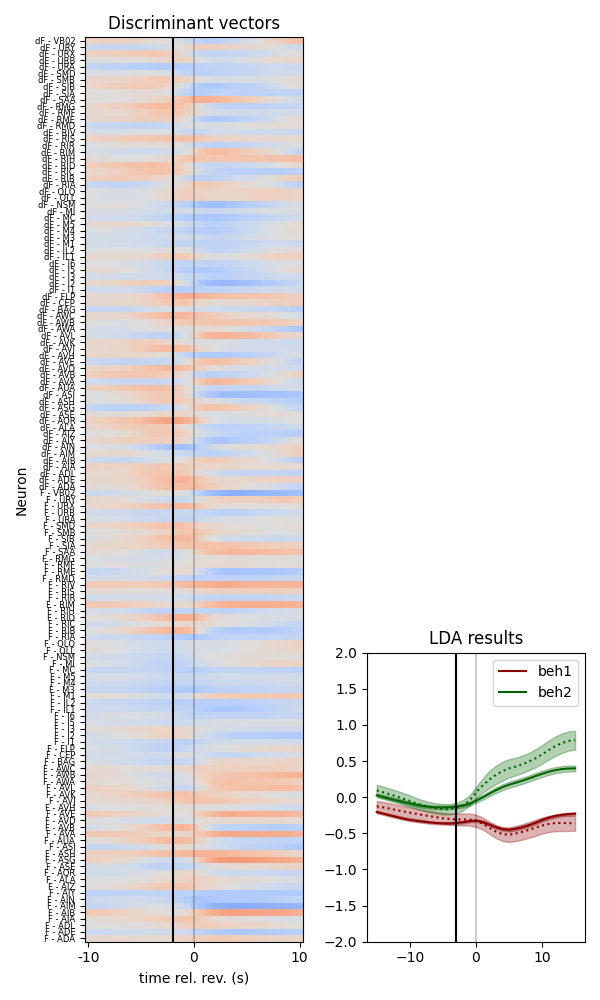

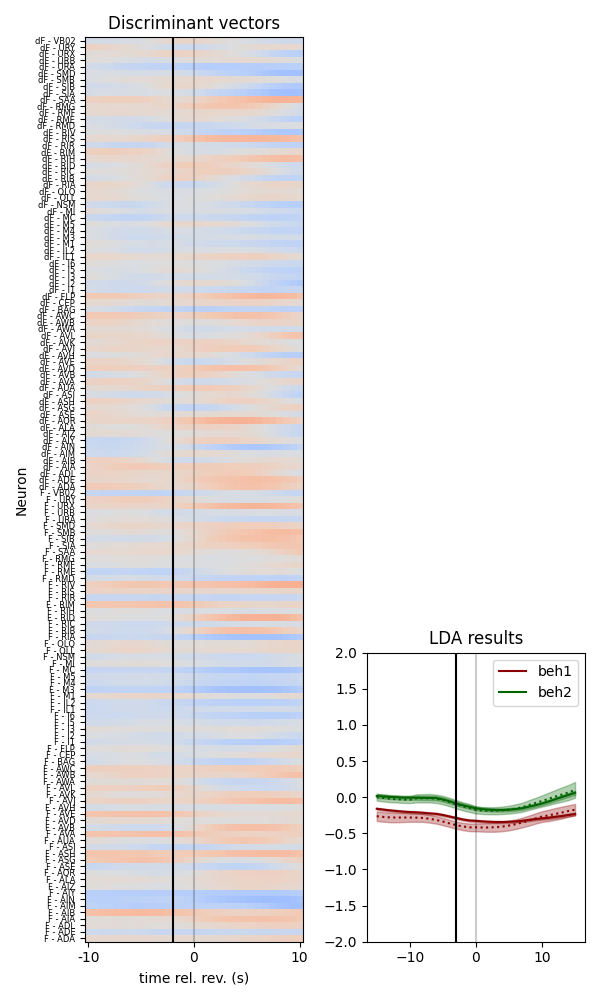

In [8]:
beh1 = select_behaviors(contiguous_behaviors, beh1="fwd", comp=">=", beh1_dur=6, prev_beh="rev", prev_comp=">=", prev_dur=6) #fwd following rev
beh2 = select_behaviors(contiguous_behaviors, beh1="turn", comp=">=", beh1_dur=6, prev_beh="rev", prev_comp=">=", prev_dur=6) #turn following rev


RELATIVE_TO_REV_END = True

if not RELATIVE_TO_REV_END:
    beh1 = beh1-1 #choose the rev before the fwd (pure rev)# errr wait i dont get it .. 
    beh2 = beh2-1 #choose the rev before the turn (rev of rev turn)

run_LDA_once(beh1,beh2, contiguous_behaviors)


RELATIVE_TO_REV_END = False

if not RELATIVE_TO_REV_END:
    beh1 = beh1-1 #choose the rev before the fwd (pure rev)# errr wait i dont get it .. 
    beh2 = beh2-1 #choose the rev before the turn (rev of rev turn)

run_LDA_once(beh1,beh2, contiguous_behaviors)


# Run it many times

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from tqdm import tqdm

def fit_svm_many_times(q_x, contiguous_behaviors, beh1, beh2, n_test=20, max_offset=15, n_shuffle=20, n_splits=5):
    instances = np.concatenate((beh1, beh2))

    def run_fit(hold_out, shuffle=False):
        accuracies = []
        for offset in tqdm(range(-max_offset, max_offset + 1)):
            neural_trajectories = []
            neural_trajectories_test = []
            labels = []
            labels_test = []

            for count, t in enumerate(instances):
                t_start = np.sum(contiguous_behaviors[0:t, 1]).astype(int) + offset
                offset_trajectories = np.concatenate(q_x)[t_start, :]

                this_label = np.random.choice([0, 1]) if shuffle else (1 if t in beh2 else 0)

                if count not in hold_out:
                    neural_trajectories.append(offset_trajectories)
                    labels.append(this_label)
                else:
                    neural_trajectories_test.append(offset_trajectories)
                    labels_test.append(this_label)

            neural_trajectories = np.array(neural_trajectories)
            neural_trajectories_test = np.array(neural_trajectories_test)
            labels = np.array(labels)
            labels_test = np.array(labels_test)

            model = LinearSVC(C=0.1, fit_intercept=False, max_iter=5000)
            model.fit(neural_trajectories, labels)
            y_pred = model.predict(neural_trajectories_test)
            accuracy = accuracy_score(labels_test, y_pred)
            accuracies.append(accuracy)

        return np.array(accuracies)

    real_accuracies_all_splits = []
    for _ in range(n_splits):
        hold_out = np.concatenate((np.random.randint(beh1.size, size=n_test), beh1.size + np.random.randint(beh2.size, size=n_test)))
        real_accuracies_all_splits.append(run_fit(hold_out, shuffle=False))
    real_accuracies_all_splits = np.array(real_accuracies_all_splits)

    shuffled_accuracies = []
    for _ in range(n_shuffle):
        hold_out = np.concatenate((np.random.randint(beh1.size, size=n_test), beh1.size + np.random.randint(beh2.size, size=n_test)))
        shuffled_accuracies.append(run_fit(hold_out, shuffle=True))
    shuffled_accuracies = np.array(shuffled_accuracies)

    offsets = np.arange(-max_offset, max_offset + 1)

    return offsets, real_accuracies_all_splits, shuffled_accuracies

offsets, real_acc, shuffled_acc = fit_svm_many_times(q_x, contiguous_behaviors, beh1, beh2, n_test=20, max_offset=17, n_shuffle=50, n_splits=2)#n_shuffle is for control svm, n_splits is for real svm. n_shuffle should be pretty high

  0%|          | 0/35 [00:00<?, ?it/s]/Users/friederikebuck/miniconda3/envs/DLC_YOLO_GUI/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
  3%|▎         | 1/35 [00:00<00:06,  4.94it/s]/Users/friederikebuck/miniconda3/envs/DLC_YOLO_GUI/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
  6%|▌         | 2/35 [00:00<00:06,  4.99it/s]/Users/friederikebuck/miniconda3/envs/DLC_YOLO_GUI/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
  9%|▊         | 3/35 [00:00<00:06,  5.01it/s]/Users/frie

In [10]:
def plot_svm_accuracy(offsets, real_accuracies_all_splits, shuffled_accuracies):
    real_mean = real_accuracies_all_splits.mean(axis=0)
    real_std = real_accuracies_all_splits.std(axis=0)

    shuffle_mean = shuffled_accuracies.mean(axis=0)
    shuffle_std = shuffled_accuracies.std(axis=0)

    fig,ax = plt.subplots(figsize=(8, 5))
    ax.plot(offsets*0.6, real_mean, label="Decoder accuracy", color="blue")
    ax.fill_between(offsets*0.6, real_mean - real_std, real_mean + real_std, alpha=0.3, color="blue")

    ax.plot(offsets*0.6, shuffle_mean, label="Shuffled accuracy", color="gray")
    ax.fill_between(offsets*0.6, shuffle_mean - shuffle_std, shuffle_mean + shuffle_std, alpha=0.3, color="gray")

    ax.axvline(0, color="k", linestyle=":", alpha=0.5)
    ax.axvline(-1.8, color="k", linestyle=":", alpha=0.5)
    return fig,ax



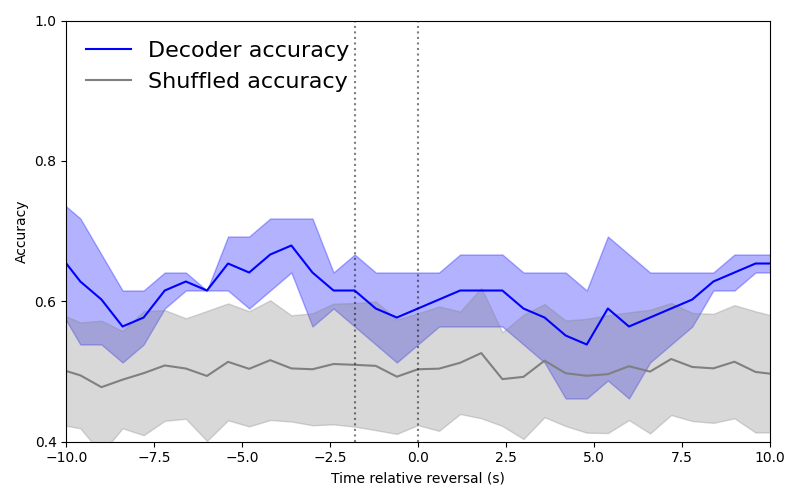

In [11]:
fig,ax = plot_svm_accuracy(offsets, real_acc, shuffled_acc)
ax.set_ylim(0.4, 1)
ax.set_xlim(-10,10)
ax.set_yticks([0.4, 0.6, 0.8, 1])
ax.set_xlabel("Time relative reversal (s)")
ax.set_ylabel("Accuracy")

ax.legend(loc="upper left", fontsize=16, frameon=False)
fig.tight_layout()
